# Public Opinion Evaluation on Social Media Platforms 
This notebook shows the sentiment analysis experiment on HighSpeed 2 tweets data. 


## 1. Set-up Python environment 
Loading Python libraries

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Set up GPU units

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


## 2. Dataset
Loading taged tweets to this notebook. The negative tweet were labeled with 0, and the non-negative (neutral and positive) tweets were labeled with 1


In [ ]:
# Mount google dirve
from google.colab import drive
drive.mount('/content/drive')

# Load non-negative data 
data_non_negative = pd.read_csv('/content/drive/MyDrive/Data/data_non_negative.csv')

# Load negative data
data_negative = pd.read_csv('/content/drive/MyDrive/Data/data_negative.csv')

# Concatenate training data
data = pd.concat([data_non_negative, data_negative], axis=0).reset_index(drop=True)

# Display 10 random samples
data.sample(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Text,Label,Sentiment
319,The @MayorofGM and @MetroMayorSteve know how v...,1,positive
785,#hs2 Another huge infrastructure project (????...,0,negative
1144,Look how empty #HS2 trains would be based on c...,0,negative
1241,This is #CrimToryEngland where Private Compani...,0,negative
845,LandLove - News - Several hundred years old oa...,0,negative
985,Another #PR consultancy tweet bigging up #hs2 ...,0,negative
648,More than ?8 million of government funding wil...,1,neutral
81,1/2 #NetworkRail are establishing a #HS2 Integ...,1,positive
1193,Carillion liquidator hits KPMG with negligence...,0,negative
209,HS2 must be ��X-shaped�� to bring high-speed s...,1,positive


In [ ]:
from sklearn.model_selection import train_test_split

X = data.Text.values
y = data.Label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.3, random_state=88)


## 3. Multinomial Naive Bayes Classifier
### 3.1 Preprocessing tweets

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

# define a function to preprocee tweets
def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Vectorizing tweets
Using term frequency-inverse document frequency (TF-IDF) to retrieve information in tweets. 

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess tweets
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 5.81 s, sys: 837 ms, total: 6.65 s
Wall time: 8.8 s


### Setting up performance measure

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_accuracy(probs, y_true):
    """
    """
    preds = probs[:, 1]
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    
def evaluate_roc(probs, y_true, title):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.figure(figsize=(6,4))
    plt.figure(dpi=600)
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.rcParams['font.size'] = 11  # Set the font size
    plt.show()


### Fine-tun the hyperparameter (alpha) with grid search

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
param_grid_mnb = {
    'alpha':[0.1,0.15, 0.2,0.25, 0.3,0.35,0.4,0.45,0.5,0.55,
             0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0],
    'fit_prior':[True, False]
}

# Create the MultinomialNB classifier
MNB_classifier = MultinomialNB()

# Perform grid search with cross-validation
grid_search_mnb = GridSearchCV(MNB_classifier, param_grid_mnb, cv=5)
grid_search_mnb.fit(X_train_tfidf,y_train)

alpha = grid_search_mnb.best_params_
# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters: ", alpha)

Best Hyperparameters:  {'alpha': 0.1, 'fit_prior': True}


## MNB experiment

AUC: 0.9023
Accuracy: 82.62%


<Figure size 600x400 with 0 Axes>

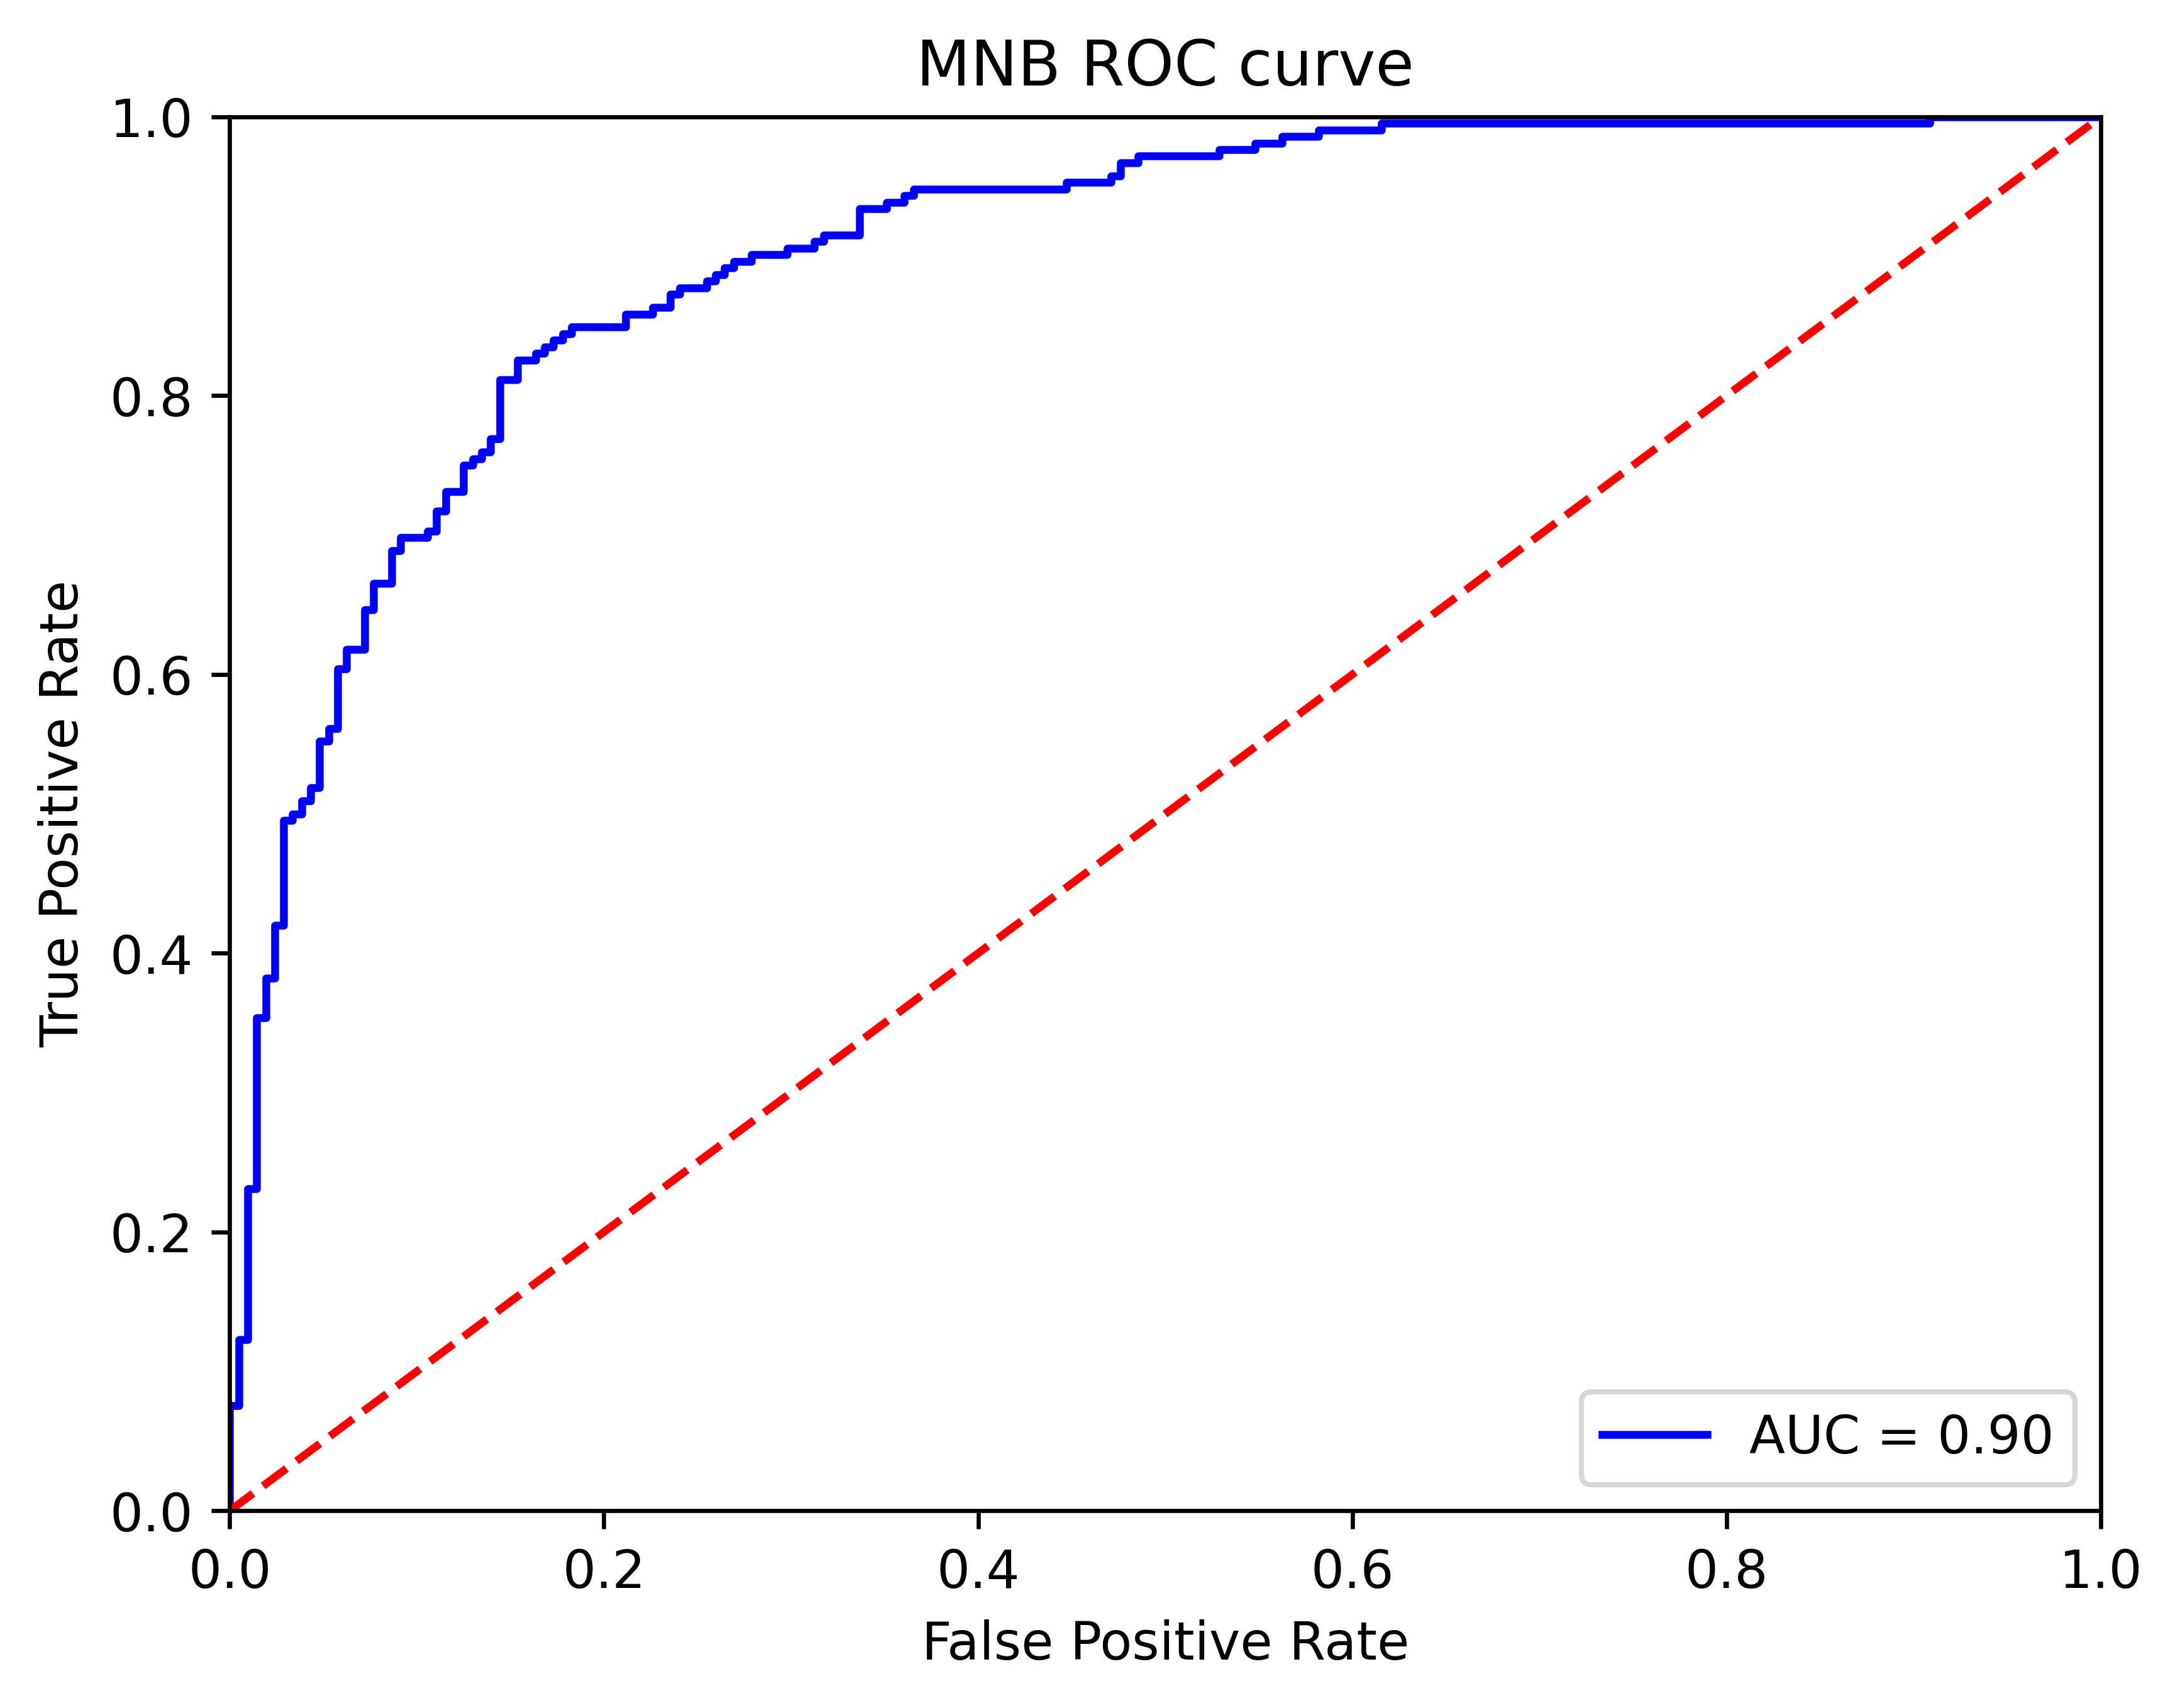

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)
probs_MNB = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
title_MNB = 'MNB ROC curve'
evaluate_roc(probs_MNB, y_val,title=title_MNB)


## VaderSentiment 
A lexicon rule based text sentiment analysis

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def Vader(X_val):
  analyzer = SentimentIntensityAnalyzer()
  prob_vader = np.zeros((X_val.shape[0],2))
  for i, item in enumerate(X_val):
    sentiment = analyzer.polarity_scores(item)
    if sentiment['compound'] <= -0.05:
      prob_vader[i][0] = 0
    else:  
      prob_vader[i][1] = 1
  
  return prob_vader

In [ ]:
prob_vader=Vader(X_val)
evaluate_accuracy(prob_vader, y_val)


Accuracy: 70.24%


## Fine-tune RoBERTa classifier

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
from transformers import RobertaTokenizer

# Load the RoBerta tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Create a function to tokenize a set of texts
def preprocessing_for_roberta(data):

    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 128

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_roberta([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_roberta(X_train)
val_inputs, val_masks = preprocessing_for_roberta(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  "#HS2 will deliver a step-change in connectivity between #WestMidlands &amp; key centres of #North of England providing the economic “Drive-train” that will link the @midsengine with the @NPHinfo"\n#NorthernPowerhouse\n#MidlandsEngine\n@MidsConnect\n#HS2AllTheWay\nhttps://t.co/rFEF1HVI7P
Token IDs:  [0, 113, 10431, 6391, 176, 40, 2438, 10, 1149, 12, 14035, 11, 10335, 227, 849, 9634, 30238, 8391, 359, 762, 7872, 9, 849, 11073, 9, 1156, 1976, 5, 776, 44, 48, 29279, 12, 21714, 17, 46, 14, 40, 3104, 5, 19, 5, 787, 487, 7561, 23999, 113, 37457, 282, 10431, 37982, 20645, 3138, 37457, 282, 10431, 30238, 8391, 13929, 37457, 282, 1039, 448, 7823, 31161, 37457, 282, 10431, 6391, 176, 3684, 133, 24450, 37457, 282, 13082, 640, 90, 4, 876, 73, 338, 10885, 597, 134, 725, 15176, 406, 510, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokenizing data...


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import RobertaModel

# Create the BertClassfier class
class RobertaClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        
        super(RobertaClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 256, 2

        # Instantiate BERT model
        self.roberta = RobertaModel.from_pretrained('roberta-base')

         # Instantiate an one-layer feed-forward classifier
        self.rnn = nn.LSTM(input_size=768,
                          hidden_size=H, 
                          num_layers=2, 
                          bidirectional=True,
                          dropout = 0.5
                          )
        self.fc = nn.Linear(H*2, D_out)
        
        
    def forward(self, input_ids, attention_mask):
        
        # Feed input to RoBERTa
        outputs_roberta = self.roberta(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        embedded = outputs_roberta[0][:,0,:]

        # Feed input to classifier to compute logits
        outputs, _ = self.rnn (embedded)
        logits = self.fc(outputs)
        return logits

CPU times: user 47.2 ms, sys: 0 ns, total: 47.2 ms
Wall time: 48.4 ms


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs):
    
    # Instantiate Bert Classifier
    roberta_classifier = RobertaClassifier()

    # Tell PyTorch to run the model on GPU
    roberta_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(roberta_classifier.parameters(),
                      lr=2e-6,    
                      eps=1e-8    
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return roberta_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
set_seed(66)    # Set seed for reproducibility
roberta_classifier, optimizer, scheduler = initialize_model(epochs=100)
train(roberta_classifier, train_dataloader, val_dataloader, epochs=100, evaluation=True)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  war

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.689268   |     -      |     -     |   7.31   
   1    |   40    |   0.697077   |     -      |     -     |   6.80   
   1    |   60    |   0.692239   |     -      |     -     |   6.94   
   1    |   61    |   0.694667   |     -      |     -     |   0.12   
----------------------------------------------------------------------
   1    |    -    |   0.692832   |  0.693001  |   50.46   |   24.03  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.694319   |     -      |     -     |   7.33   
   2    |   40    |   0.693800   |     -      |     -     |   7.03   
   2    |   60    |   0.693077   |     -      |     -     |   7.1

In [ ]:
import torch.nn.functional as F

def roberta_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.8904
Accuracy: 89.52%


<Figure size 600x400 with 0 Axes>

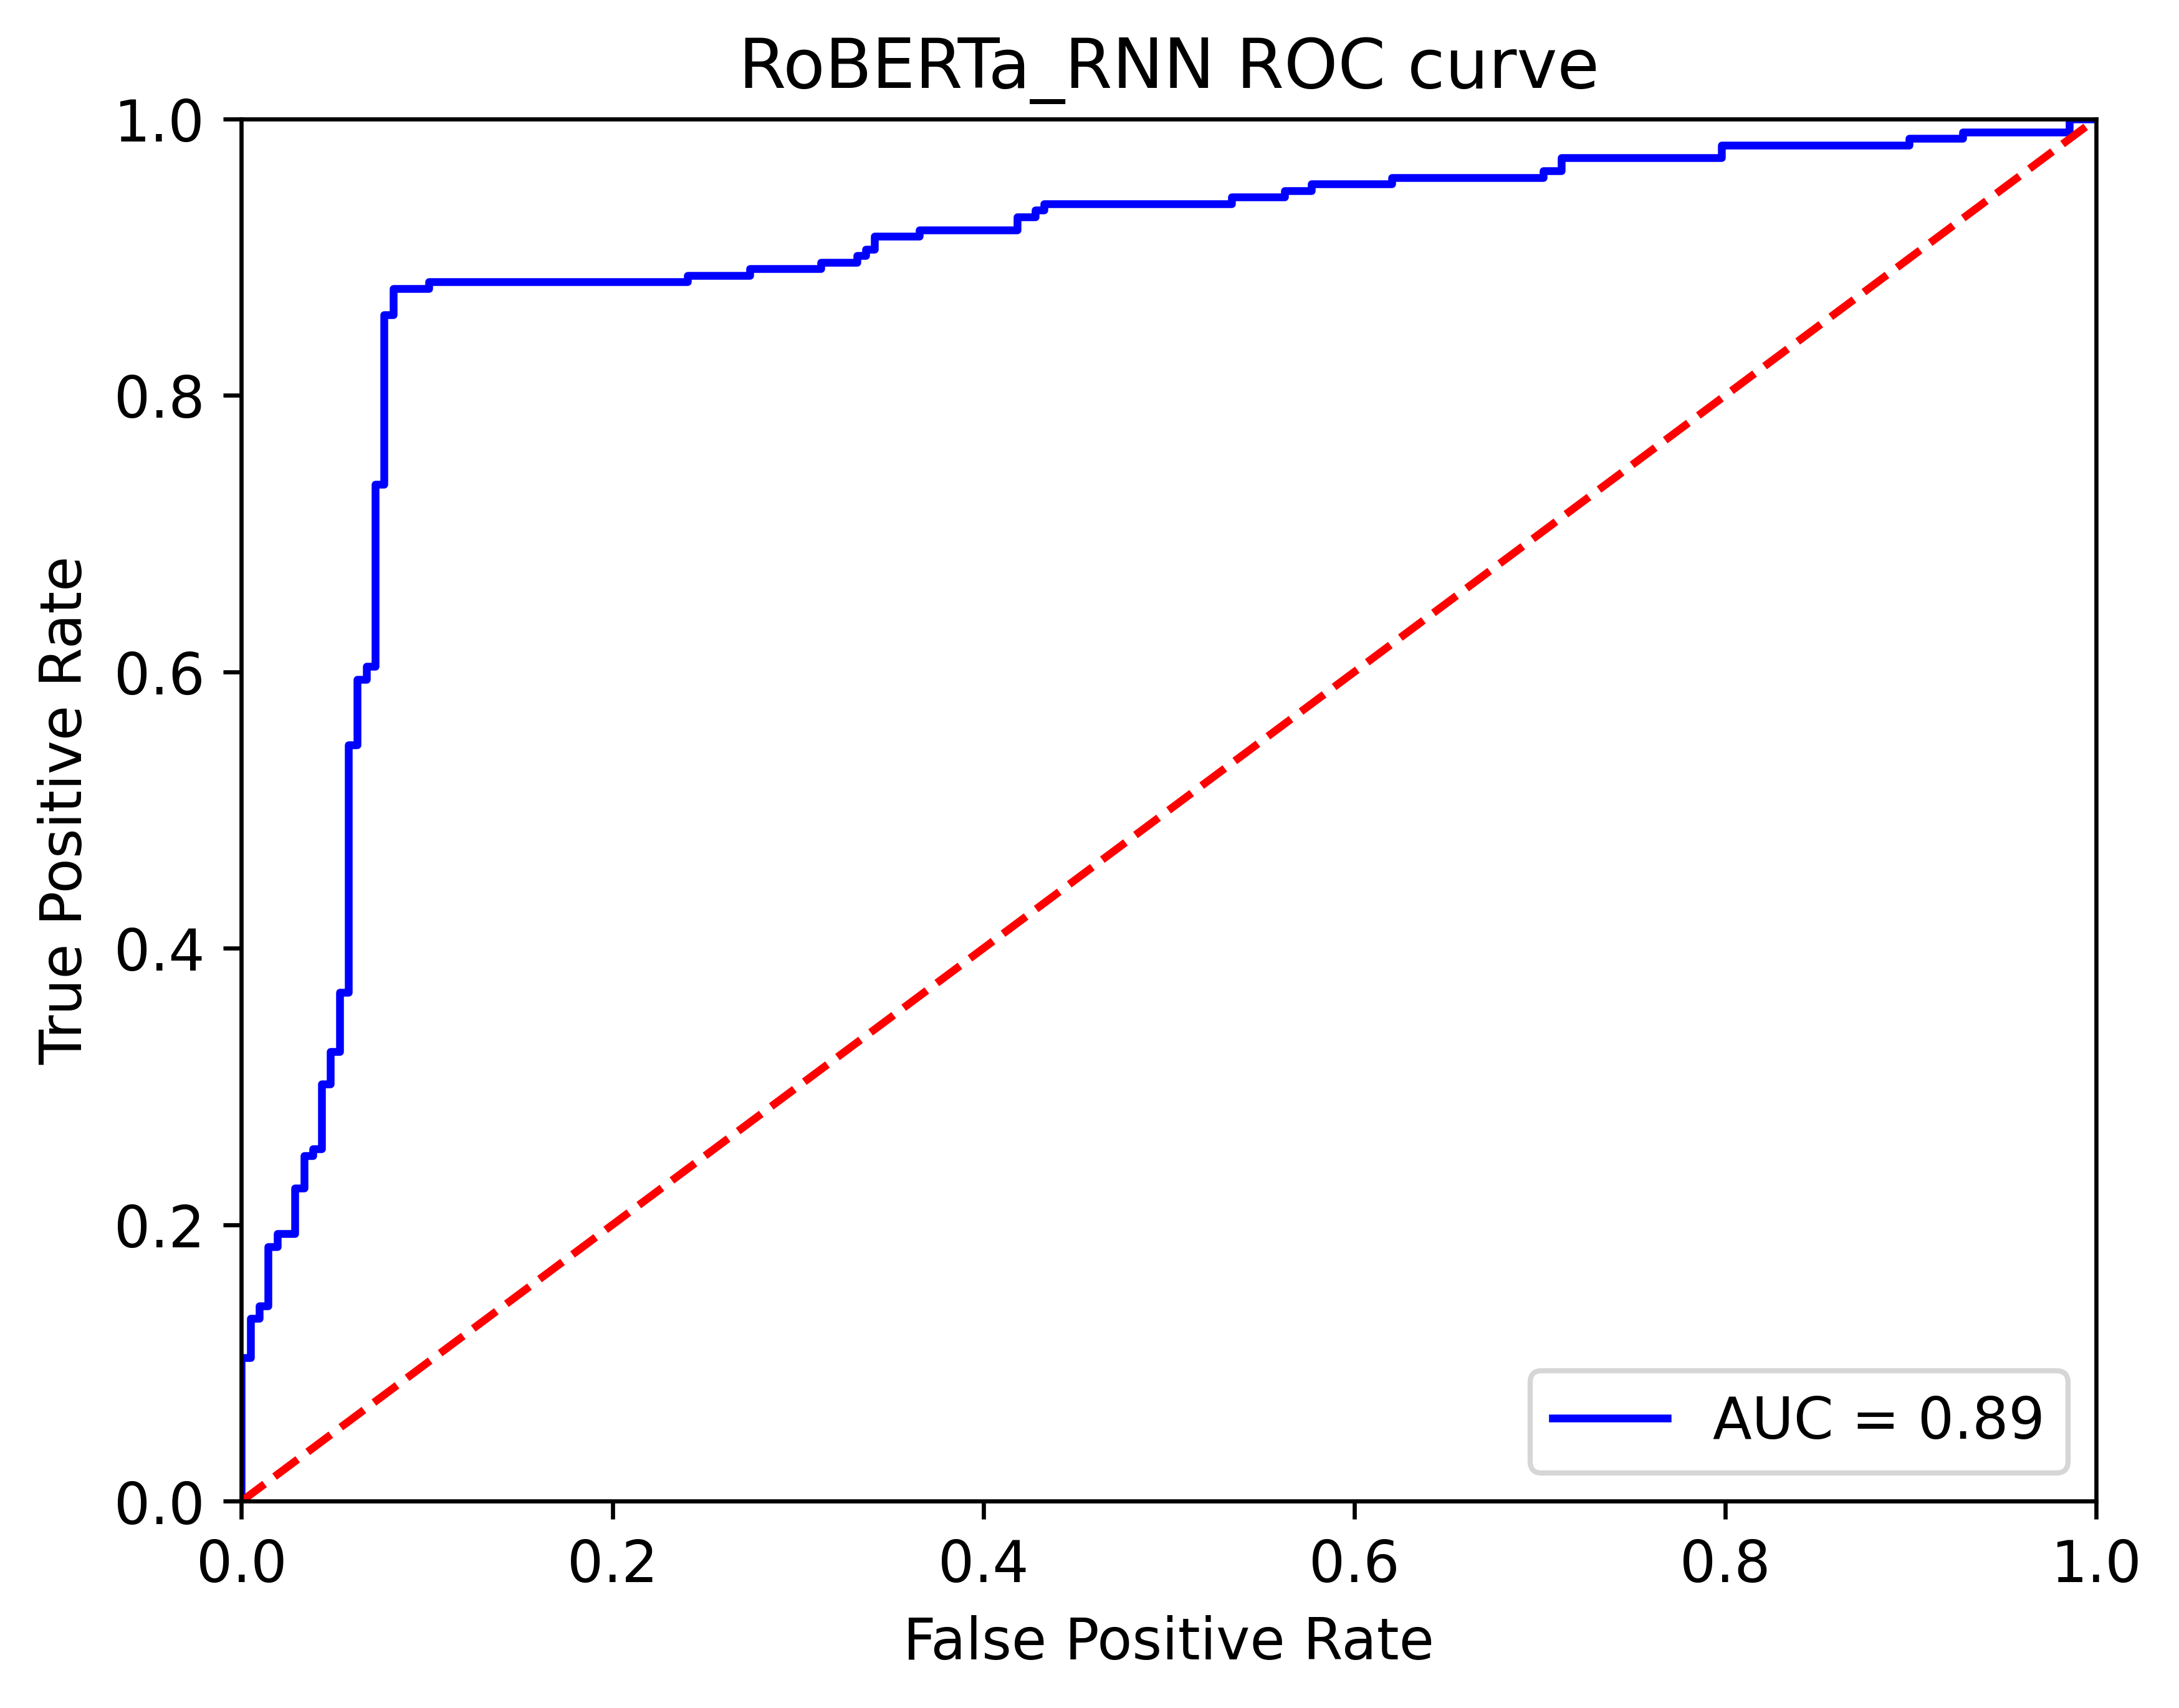

In [ ]:
# Compute predicted probabilities on the test set
probs_roberta = roberta_predict(roberta_classifier, val_dataloader)
title_RoBERTa = 'RoBERTa_RNN ROC curve'

# Evaluate the Bert classifier
evaluate_roc(probs_roberta, y_val,title=title_RoBERTa)